<h1><center> 
    CPT_S 434/534 Neural network design and application
</center></h1>

<!-- <h2><center>CPT_S 434/534</center></h2> -->

<h2><center>HW 1: ML -- code (80 pts)</center></h2>

### Name: *[Yuqun Song]*

### Student ID: *[11678637]*

## This assignment includes:

## Coding in Python (pytorch): train a regularized Softmax classifier on MNIST 

### Step 0: Install and configure: python ([Anaconda platform](https://docs.anaconda.com/anaconda/install/) recommended), [Jupyter Notebook](https://jupyter.org/install), [pytorch](https://pytorch.org/get-started/), [torchvision](https://anaconda.org/pytorch/torchvision), etc.

**Remark 1.** [Colab](https://colab.research.google.com) is a cloud platform that enables your Jupyter Notebooks (including this .ipynb assignment) to run with different runtime types (hardware acceleration is possible using GPU or TPU). You may also choose Colab to finish assignments (future assignments may require extensive computation that may be time-consuming on your laptop such as 1 or 2 hours). 

**Remark 2.** If you use Colab, make sure the working path/directory is the current one. See [this page](https://stackoverflow.com/questions/48298146/changing-directory-in-google-colab-breaking-out-of-the-python-interpreter).

**Remark 3.** If you use Colab, it is still required to convert your .ipynb to .html and submit **BOTH** files to Canvas. See [this page](https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab) on how to convert to .html using Colab

### Step 1: Read the [provided document](CPTS434_534_HW1_note.pdf) to understand how to train a regularized Softmax classifier:

**Remark 1.** What is the problem setting of the multiclass classification

**Remark 2.** What is Cross-Entropy loss and $\color{red}{\text{the objective function of the regularized Softmax classifier}}$

**Remark 3.** How to compute the gradients of the objective function w.r.t. the weight matrix/vectors

**Remark 4.** What is the general algorithmic process of mini-batch SGD

### Step 2: Read provided code (with pytorch) to understand the logic of design and target, so that you know how to implement in the following step and incorporate your code into the provided code

### Step 3: Complete the code

#### 1) "mini_batch_gradient()" (**36 pts**) for computing mini-batch stochastic gradients in MB-SGD, and train the linear model with setting 1

#### 2) write the configure files for other 6 new settings and train their classifiers (4 pts each, **24 pts** in total). 

### Step 4: Record and plot results to show the loss and accuracy convergence (against #epoch)

### Step 5: Answer the five questions at the end of this file (4 pts each, **20 pts** in total)

## $\color{red}{\text{Submission:}}$

* Convert the .ipynb file to .html file (**save the execution outputs** to show your progress: otherwise grading may be affected)
    
* Upload **both** your .ipynb and .html files to Canvas separately (not zip them to a single zip file).

* Plots should be clear and easy to read.

## 1. (Read and run) Load/Download MNIST dataset using pytorch

In [4]:
import matplotlib.pyplot as plt
import numpy
from torchvision import datasets, transforms

train_set = datasets.MNIST('./data', train=True, download=True)
test_set = datasets.MNIST('./data', train=False, download=True)

x_train = train_set.data.numpy()
x_train = x_train.reshape(len(x_train),-1)
x_test = test_set.data.numpy()
x_test = x_test.reshape(len(x_test),-1)

y_train = train_set.targets.numpy()
y_test = test_set.targets.numpy()

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (60000, 784)
Shape of x_test: (10000, 784)
Shape of y_train: (60000,)
Shape of y_test: (10000,)


## 2. (Read and run) Scale features

In [6]:
# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

## 3. (Read and run) Visualize a random image

Its label is
2


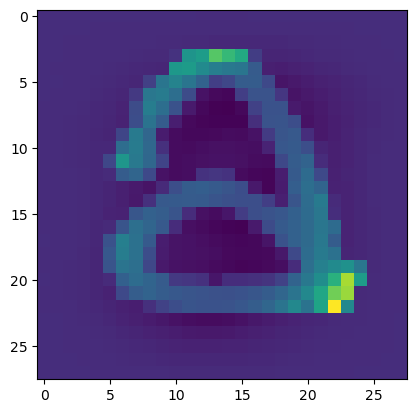

In [10]:
d = x_train.shape[0]
random_index = numpy.random.randint(d, size=1)[0]
plt.imshow(x_train[random_index].reshape(28,28))
print('Its label is')
print(y_train[random_index])

## 4. (Read and run) Define softmax function and cross entropy loss

In [13]:
def softmax(z):
    """implement the softmax functions
    input: numpy ndarray
    output: numpy ndarray
    """
    exp_list = numpy.exp(z)
    result = 1/sum(exp_list) * exp_list
    result = result.reshape((len(z),1))
    assert (result.shape == (len(z),1))
    return result

def neg_log_loss(pred, label):
    """implement the negative log loss"""
    loss = -numpy.log(pred[int(label)])
    return loss




## 5. (Read and run) Functions for implementing linear softmax classifier

In [16]:
import os
import sys
import json

root = os.path.abspath('.')
root += '/configs/'

def loadConfig(name):
    """ Read a configuration file as a dictionary"""
    full_path = root + name
    json_file = open(full_path, 'r')
    cfg = json.load(json_file)
    json_file.close()
    return cfg  

def initialize(num_inputs,num_classes):
    """initialize the parameters"""
    # num_inputs = 28*28 = 784
    # num_classes = 10
    w = numpy.zeros((num_classes, num_inputs)) # (10*784)
    
    param = {
        'w' : w, # (10*784)
    }
    return param

def eval(param, hyp, x_data, y_data):
    """ implement the evaluation function
    input: param -- parameters dictionary (w)
           hyp -- hyper-parameter: we use hyp['lambda'] to compute regularization
           x_data -- x_train or x_test (size, 784)
           y_data -- y_train or y_test (size,)
    output: loss and accuracy
    """
    
    reg_lambda = hyp['lambda']
    
    # w: (10*784), x: (10000*784), y:(10000,)
    loss_list = []
    w = param['w'].transpose()
    dist = numpy.array([numpy.squeeze(softmax(numpy.matmul(x_data[i], w))) for i in range(len(y_data))])

    result = numpy.argmax(dist,axis=1)
    accuracy = sum(result == y_data)/float(len(y_data))

    loss_list = [neg_log_loss(dist[i],y_data[i]) for i in range(len(y_data))]
    loss = sum(loss_list) / len(loss_list) + reg_lambda/2 * numpy.sum(w * w)
    return loss, accuracy

def train(param, hyp, x_train, y_train, x_test, y_test,cfg_idx):
    """ implement the train function
    input: param -- parameters dictionary (w)
           hyp -- hyperparameters dictionary
           x_train -- (60000, 784)
           y_train -- (60000,)
           x_test -- x_test (10000, 784)
           y_test -- y_test (10000,)
    output: train_loss_list, train_acc_list, test_loss_list, test_acc_list
           Four lists contain the epoch-wise loss function on training data, accuracy on training data, loss function on testing data, accuracy on testing data, respectively
    """
    num_epoches = hyp['num_epoches']
    batch_size = hyp['batch_size']
    learning_rate = hyp['learning_rate']
    mu = hyp['mu']
    reg_lambda = hyp['lambda']
    train_loss_list, train_acc_list, test_loss_list, test_acc_list = [],[],[],[]
    if bool(hyp['momentum']) == True:
        w_velocity = numpy.zeros(param['w'].shape)
        b_velocity = numpy.zeros(param['b'].shape) 

    for epoch in range(num_epoches):
        
        # select the random sequence of training set
        rand_indices = numpy.random.choice(x_train.shape[0],x_train.shape[0],replace=False)
        num_batch = int(x_train.shape[0]/batch_size)
        
        if bool(hyp['learning_decay']) == True:
            try:
                if test_acc_list[-1] - test_acc_list[-2] < 0.001:
                    learning_rate *= hyp['decay_factor']
            except:
                pass
            
            message = 'learning rate: %.8f' % learning_rate
            print(message)
            logging.info(message)

        # for each batch of train data
        for batch in range(num_batch):
            index = rand_indices[batch_size*batch:batch_size*(batch+1)]
            x_batch = x_train[index]
            y_batch = y_train[index]

            # calculate the stochastic gradient w.r.t w 
            dw, batch_loss = mini_batch_gradient(param, x_batch, y_batch, reg_lambda)

            param['w'] -= learning_rate * dw
            
            if (batch+1) % 100 == 0:
                message = 'Epoch [%d/%d], Batch [%d/%d], Loss %.4f' % (epoch+1, num_epoches, batch+1, num_batch, batch_loss)
                print(message)

        train_loss, train_acc = eval(param,hyp,x_train,y_train)
        test_loss, test_acc = eval(param,hyp,x_test,y_test)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)

        message = 'Epoch %d/%d, Train Loss %.4f, Train Acc %.4f, Test Loss %.4f, Test Acc %.4f' % (epoch+1, num_epoches, train_loss, train_acc, test_loss, test_acc)
        print(message)
        logging.info(message)
    return train_loss_list, train_acc_list, test_loss_list, test_acc_list


def plot(train_loss_list, train_acc_list, test_loss_list, test_acc_list, cfg_idx):
    """store the plots"""
    # epoch_list = list(range(len(loss_list)))
    plt.plot(train_loss_list, '-b', label='train loss')
    plt.plot(test_loss_list, '-r', label='test loss')
    plt.legend()
    plt.ylabel('Loss Function')
    plt.xlabel('Epoch')
    plt.xticks(rotation=60)
    plt.title('Loss Function ~ Epoch')
    plt.savefig('assets/loss_{}.png'.format(cfg_idx))
    plt.show()
    
    plt.plot(train_acc_list, '-b', label='train acc')
    plt.plot(test_acc_list, '-r', label='test acc')
    plt.legend()
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(rotation=60)
    plt.title('Accuracy ~ Epoch')
    plt.savefig('assets/accr_{}.png'.format(cfg_idx))
    plt.show()
    

def main(cfg_idx): 
#     cfg_idx = args.config
    cfg_name = 'config_{}.json'.format(cfg_idx)
    hyperpara = loadConfig(cfg_name)

    # setting the random seed
    numpy.random.seed(1024)

    # initialize the parameters
    num_inputs = x_train.shape[1]
    num_classes = len(set(y_train))
    param = initialize(num_inputs,num_classes)

    # train the model
    train_loss_list, train_acc_list, test_loss_list, test_acc_list = train(param,hyperpara,x_train,y_train,x_test,y_test, cfg_idx)

    # plot the loss and accuracy
    plot(train_loss_list, train_acc_list, test_loss_list, test_acc_list, cfg_idx)

## 6. (To finish, 36 pts) Implementation of mini-batch gradients

In [50]:
import numpy as np
def mini_batch_gradient(param, x_batch, y_batch, reg_lambda):
    """implement the function to compute the mini batch gradient
    input: param -- parameters dictionary (w)
           x_batch -- a batch of x (size, 784)
           y_batch -- a batch of y (size,)
           reg_lambdba -- regularization parameter
    output: 
           dw -- derivative w.r.t. weight w
           batch_loss -- average loss on the mini-batch samples
    """
    
    # Your code goes here
    w = param['w']
    dw = np.zeros_like(w)
    batch_loss = 0

    for i in range(x_batch.shape[0]):
        x = x_batch[i]
        y = y_batch[i]
        denom = 0
        allval = np.zeros(10)
        for j in range(10):
            allval[j] = np.exp(np.matmul(w[j],x))
            denom = np.sum(allval)

        loss = -np.log(allval[y]/denom)
        batch_loss += loss
        for k in range(10):
            if k ==y:
                dw[k] += (allval[k]/denom-1)*x
            else:
                dw[k] += (allval[k]/denom)*x

    dw = (dw/x_batch.shape[0]) + (reg_lambda*w)
    batch_loss /= x_batch.shape[0]
    
    return dw, batch_loss

## 7. (Read and run) Train your model using the provided configuration "setting 1" (in *configs/config_setting_1.json*) untill convergence 

Epoch 1/50, Train Loss 0.6474, Train Acc 0.8485, Test Loss 0.6310, Test Acc 0.8568
Epoch 2/50, Train Loss 0.5096, Train Acc 0.8733, Test Loss 0.4951, Test Acc 0.8789
Epoch 3/50, Train Loss 0.4527, Train Acc 0.8830, Test Loss 0.4399, Test Acc 0.8868
Epoch 4/50, Train Loss 0.4203, Train Acc 0.8897, Test Loss 0.4088, Test Acc 0.8923
Epoch 5/50, Train Loss 0.3988, Train Acc 0.8931, Test Loss 0.3886, Test Acc 0.8971
Epoch 6/50, Train Loss 0.3833, Train Acc 0.8964, Test Loss 0.3741, Test Acc 0.8994
Epoch 7/50, Train Loss 0.3713, Train Acc 0.8989, Test Loss 0.3632, Test Acc 0.9014
Epoch 8/50, Train Loss 0.3618, Train Acc 0.9008, Test Loss 0.3544, Test Acc 0.9036
Epoch 9/50, Train Loss 0.3541, Train Acc 0.9024, Test Loss 0.3475, Test Acc 0.9046
Epoch 10/50, Train Loss 0.3475, Train Acc 0.9035, Test Loss 0.3415, Test Acc 0.9055
Epoch 11/50, Train Loss 0.3419, Train Acc 0.9050, Test Loss 0.3367, Test Acc 0.9066
Epoch 12/50, Train Loss 0.3370, Train Acc 0.9062, Test Loss 0.3324, Test Acc 0.9074
E

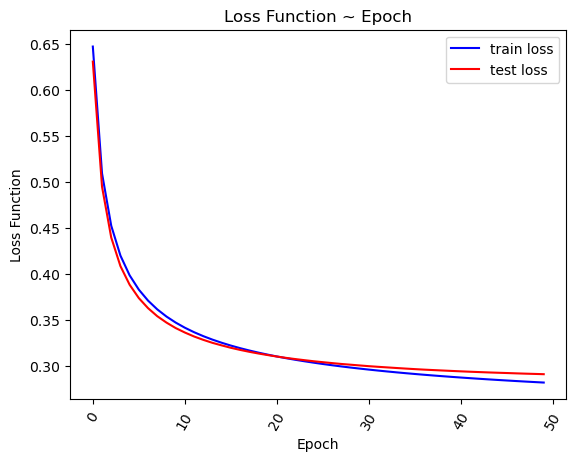

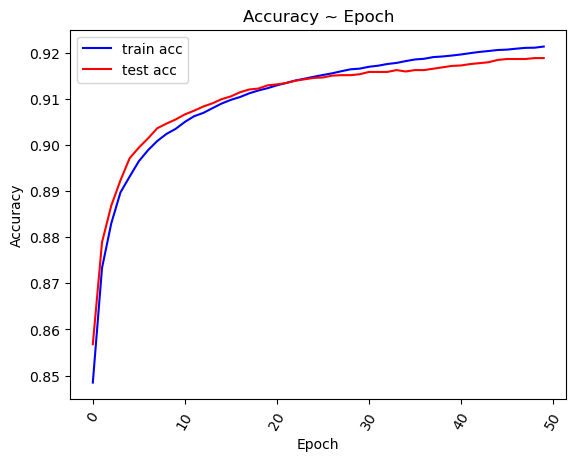

In [53]:
if os.path.isdir('logs') == False:
    os.mkdir('logs')
    
if os.path.isdir('assets') == False:
    os.mkdir('assets')
    
    
    
if __name__ == "__main__":

    cfg_idx = 'setting_1'

# configuration in setting 1:
#     {
#     "num_epoches" : 50,
#     "batch_size" : 6000,
#     "learning_rate" : 0.1,
#     "learning_decay" : 0,
#     "decay_factor" : 0.75,
#     "momentum" : 0,
#     "lambda" : 0.00,
#     "mu" : 0.9
# }
    
    import logging
    logging.basicConfig(filename="./logs/{}.log".format(cfg_idx), filemode="w", format="%(message)s", level=logging.DEBUG)
    
    main(cfg_idx)

## 8. (To finish, 4 pts) Create a new configuration file for setting 2 (see comment below) and train your model

Epoch [1/50], Batch [100/100], Loss 0.3135
Epoch 1/50, Train Loss 0.3483, Train Acc 0.9040, Test Loss 0.3427, Test Acc 0.9050
Epoch [2/50], Batch [100/100], Loss 0.3320
Epoch 2/50, Train Loss 0.3134, Train Acc 0.9120, Test Loss 0.3135, Test Acc 0.9123
Epoch [3/50], Batch [100/100], Loss 0.3006
Epoch 3/50, Train Loss 0.2981, Train Acc 0.9168, Test Loss 0.3012, Test Acc 0.9158
Epoch [4/50], Batch [100/100], Loss 0.2690
Epoch 4/50, Train Loss 0.2891, Train Acc 0.9192, Test Loss 0.2961, Test Acc 0.9165
Epoch [5/50], Batch [100/100], Loss 0.2376
Epoch 5/50, Train Loss 0.2832, Train Acc 0.9207, Test Loss 0.2931, Test Acc 0.9182
Epoch [6/50], Batch [100/100], Loss 0.2895
Epoch 6/50, Train Loss 0.2784, Train Acc 0.9218, Test Loss 0.2903, Test Acc 0.9200
Epoch [7/50], Batch [100/100], Loss 0.2112
Epoch 7/50, Train Loss 0.2747, Train Acc 0.9227, Test Loss 0.2887, Test Acc 0.9207
Epoch [8/50], Batch [100/100], Loss 0.2331
Epoch 8/50, Train Loss 0.2720, Train Acc 0.9244, Test Loss 0.2869, Test Acc

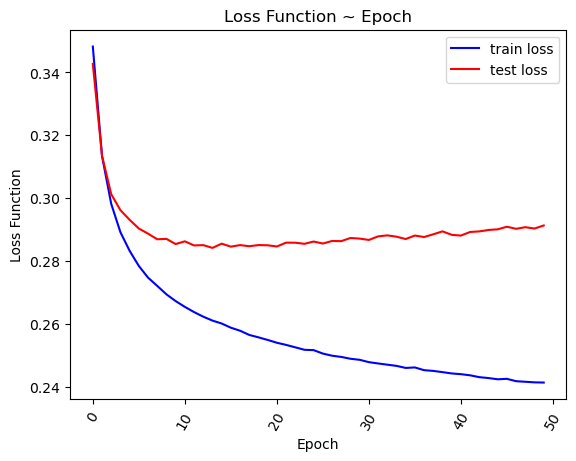

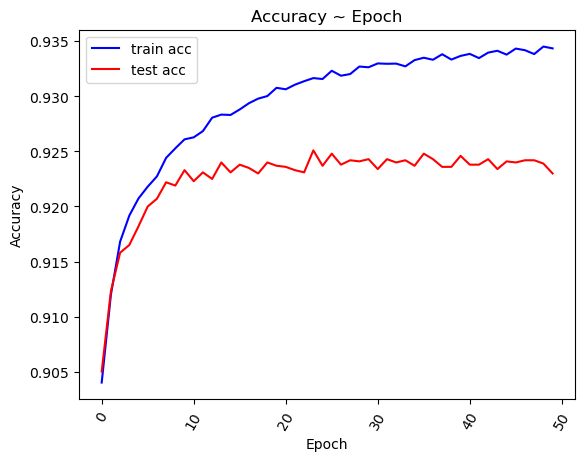

In [55]:
if __name__ == "__main__":

    cfg_idx = 'setting_2'

# configuration in setting 2:
#     {
#     "num_epoches" : 50,
#     "batch_size" : 600,
#     "learning_rate" : 0.1,
#     "learning_decay" : 0,
#     "decay_factor" : 0.75,
#     "momentum" : 0,
#     "lambda" : 0.00,
#     "mu" : 0.9
# }
    
    import logging
    logging.basicConfig(filename="./logs/{}.log".format(cfg_idx), filemode="w", format="%(message)s", level=logging.DEBUG)
    
    main(cfg_idx)    

## 9. (To finish, 4 pts) Create a new configuration file for setting 3 (see comment below) and train your model

Epoch [1/25], Batch [100/600], Loss 0.2788
Epoch [1/25], Batch [200/600], Loss 0.3185
Epoch [1/25], Batch [300/600], Loss 0.2059
Epoch [1/25], Batch [400/600], Loss 0.3359
Epoch [1/25], Batch [500/600], Loss 0.3933
Epoch [1/25], Batch [600/600], Loss 0.2960
Epoch 1/25, Train Loss 0.3023, Train Acc 0.9188, Test Loss 0.3107, Test Acc 0.9167
Epoch [2/25], Batch [100/600], Loss 0.1920
Epoch [2/25], Batch [200/600], Loss 0.3029
Epoch [2/25], Batch [300/600], Loss 0.2681
Epoch [2/25], Batch [400/600], Loss 0.2246
Epoch [2/25], Batch [500/600], Loss 0.2932
Epoch [2/25], Batch [600/600], Loss 0.4400
Epoch 2/25, Train Loss 0.2863, Train Acc 0.9222, Test Loss 0.3283, Test Acc 0.9203
Epoch [3/25], Batch [100/600], Loss 0.3315
Epoch [3/25], Batch [200/600], Loss 0.3344
Epoch [3/25], Batch [300/600], Loss 0.3618
Epoch [3/25], Batch [400/600], Loss 0.2833
Epoch [3/25], Batch [500/600], Loss 0.1602
Epoch [3/25], Batch [600/600], Loss 0.2737
Epoch 3/25, Train Loss 0.2795, Train Acc 0.9253, Test Loss 0

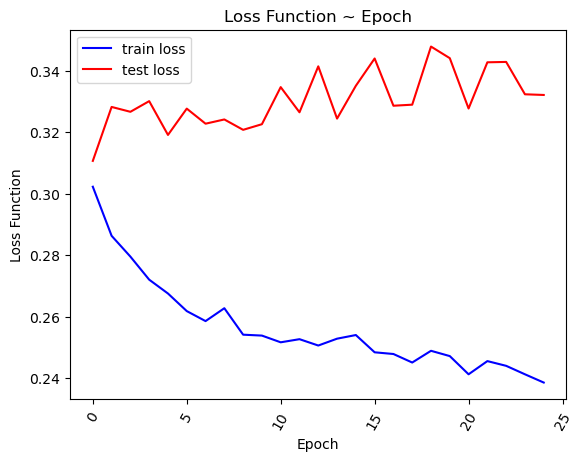

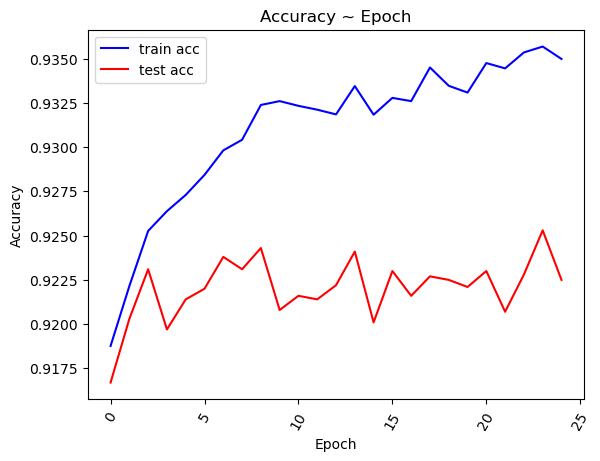

In [57]:
if __name__ == "__main__":

    cfg_idx = 'setting_3'
    
# configuration in setting 3:
#     {
#     "num_epoches" : 25,
#     "batch_size" : 100,
#     "learning_rate" : 0.1,
#     "learning_decay" : 0,
#     "decay_factor" : 0.75,
#     "momentum" : 0,
#     "lambda" : 0.00,
#     "mu" : 0.9
# }
    
    
    import logging
    logging.basicConfig(filename="./logs/{}.log".format(cfg_idx), filemode="w", format="%(message)s", level=logging.DEBUG)
    
    main(cfg_idx)
    

## 10. (To finish, 4 pts) Create a new configuration file for setting 4 (see comment below) and train your model

Epoch [1/25], Batch [100/600], Loss 0.6366
Epoch [1/25], Batch [200/600], Loss 0.5569
Epoch [1/25], Batch [300/600], Loss 0.3379
Epoch [1/25], Batch [400/600], Loss 0.3936
Epoch [1/25], Batch [500/600], Loss 0.3620
Epoch [1/25], Batch [600/600], Loss 0.4071
Epoch 1/25, Train Loss 0.3845, Train Acc 0.8962, Test Loss 0.3755, Test Acc 0.8986
Epoch [2/25], Batch [100/600], Loss 0.3242
Epoch [2/25], Batch [200/600], Loss 0.3705
Epoch [2/25], Batch [300/600], Loss 0.2986
Epoch [2/25], Batch [400/600], Loss 0.3251
Epoch [2/25], Batch [500/600], Loss 0.2891
Epoch [2/25], Batch [600/600], Loss 0.4402
Epoch 2/25, Train Loss 0.3376, Train Acc 0.9061, Test Loss 0.3332, Test Acc 0.9072
Epoch [3/25], Batch [100/600], Loss 0.4095
Epoch [3/25], Batch [200/600], Loss 0.3669
Epoch [3/25], Batch [300/600], Loss 0.4437
Epoch [3/25], Batch [400/600], Loss 0.2949
Epoch [3/25], Batch [500/600], Loss 0.1940
Epoch [3/25], Batch [600/600], Loss 0.3255
Epoch 3/25, Train Loss 0.3174, Train Acc 0.9113, Test Loss 0

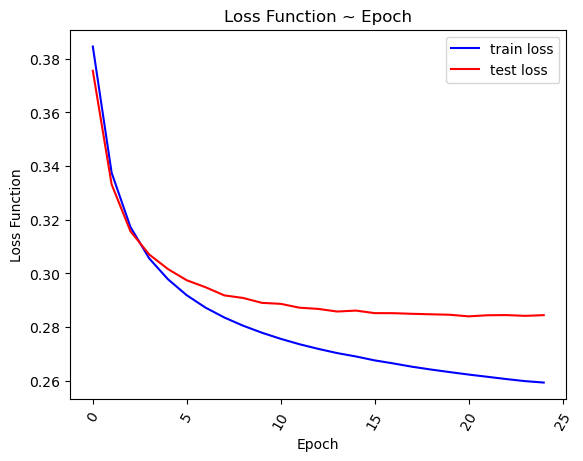

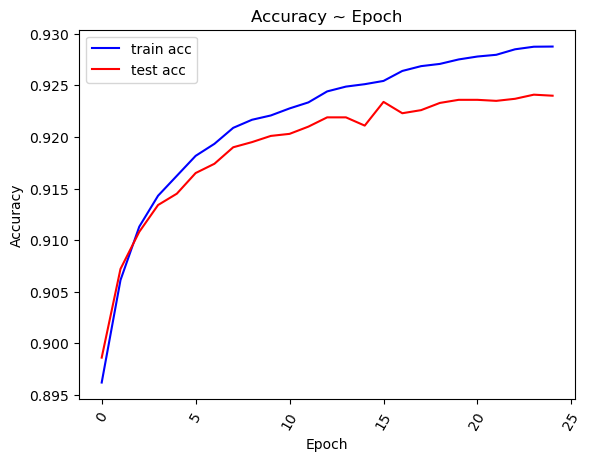

In [59]:
if __name__ == "__main__":

    cfg_idx = 'setting_4'
    
# configuration in setting 4:
# {
#     "num_epoches" : 25,
#     "batch_size" : 100,
#     "learning_rate" : 0.01,
#     "learning_decay" : 0,
#     "decay_factor" : 0.75,
#     "momentum" : 0,
#     "lambda" : 0.00,
#     "mu" : 0.9
# }
    
    
    import logging
    logging.basicConfig(filename="./logs/{}.log".format(cfg_idx), filemode="w", format="%(message)s", level=logging.DEBUG)
    
    main(cfg_idx)

## 11. (To finish, 4 pts) Create a new configuration file for setting 5 (see comment below) and train your model

Epoch [1/50], Batch [100/100], Loss 0.3143
Epoch 1/50, Train Loss 0.3519, Train Acc 0.9040, Test Loss 0.3463, Test Acc 0.9049
Epoch [2/50], Batch [100/100], Loss 0.3327
Epoch 2/50, Train Loss 0.3185, Train Acc 0.9120, Test Loss 0.3184, Test Acc 0.9123
Epoch [3/50], Batch [100/100], Loss 0.3020
Epoch 3/50, Train Loss 0.3043, Train Acc 0.9165, Test Loss 0.3071, Test Acc 0.9158
Epoch [4/50], Batch [100/100], Loss 0.2706
Epoch 4/50, Train Loss 0.2961, Train Acc 0.9189, Test Loss 0.3027, Test Acc 0.9165
Epoch [5/50], Batch [100/100], Loss 0.2393
Epoch 5/50, Train Loss 0.2909, Train Acc 0.9206, Test Loss 0.3002, Test Acc 0.9183
Epoch [6/50], Batch [100/100], Loss 0.2905
Epoch 6/50, Train Loss 0.2867, Train Acc 0.9215, Test Loss 0.2980, Test Acc 0.9200
Epoch [7/50], Batch [100/100], Loss 0.2137
Epoch 7/50, Train Loss 0.2836, Train Acc 0.9225, Test Loss 0.2967, Test Acc 0.9199
Epoch [8/50], Batch [100/100], Loss 0.2358
Epoch 8/50, Train Loss 0.2815, Train Acc 0.9239, Test Loss 0.2953, Test Acc

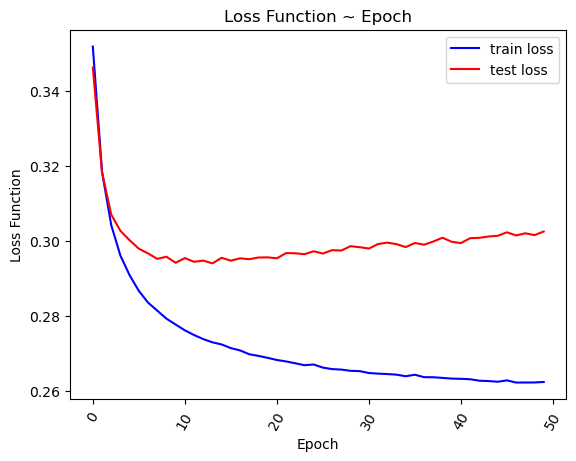

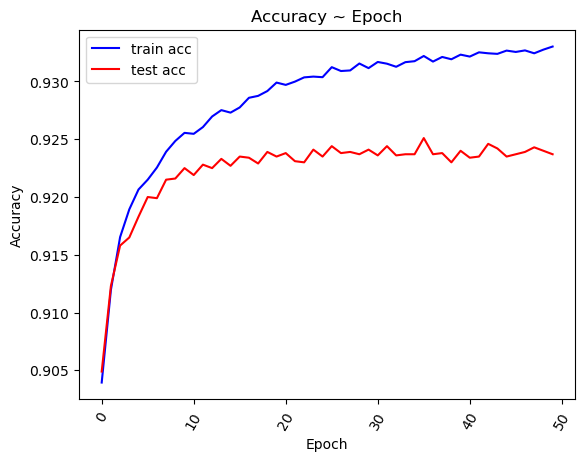

In [61]:
if __name__ == "__main__":

    cfg_idx = 'setting_5'
    
# configuration in setting 5:
#     {
#     "num_epoches" : 50,
#     "batch_size" : 600,
#     "learning_rate" : 0.1,
#     "learning_decay" : 0,
#     "decay_factor" : 0.75,
#     "momentum" : 0,
#     "lambda" : 0.001,
#     "mu" : 0.9
# }
    
    
    import logging
    logging.basicConfig(filename="./logs/{}.log".format(cfg_idx), filemode="w", format="%(message)s", level=logging.DEBUG)
    
    main(cfg_idx)

## 12. (To finish, 4 pts) Create a new configuration file for setting 6 (see comment below) and train your model

Epoch [1/50], Batch [100/100], Loss 0.3215
Epoch 1/50, Train Loss 0.3826, Train Acc 0.9032, Test Loss 0.3764, Test Acc 0.9041
Epoch [2/50], Batch [100/100], Loss 0.3399
Epoch 2/50, Train Loss 0.3596, Train Acc 0.9110, Test Loss 0.3582, Test Acc 0.9115
Epoch [3/50], Batch [100/100], Loss 0.3162
Epoch 3/50, Train Loss 0.3520, Train Acc 0.9147, Test Loss 0.3525, Test Acc 0.9141
Epoch [4/50], Batch [100/100], Loss 0.2864
Epoch 4/50, Train Loss 0.3487, Train Acc 0.9163, Test Loss 0.3520, Test Acc 0.9156
Epoch [5/50], Batch [100/100], Loss 0.2564
Epoch 5/50, Train Loss 0.3468, Train Acc 0.9180, Test Loss 0.3520, Test Acc 0.9161
Epoch [6/50], Batch [100/100], Loss 0.3031
Epoch 6/50, Train Loss 0.3455, Train Acc 0.9184, Test Loss 0.3517, Test Acc 0.9170
Epoch [7/50], Batch [100/100], Loss 0.2367
Epoch 7/50, Train Loss 0.3449, Train Acc 0.9193, Test Loss 0.3517, Test Acc 0.9172
Epoch [8/50], Batch [100/100], Loss 0.2605
Epoch 8/50, Train Loss 0.3446, Train Acc 0.9198, Test Loss 0.3511, Test Acc

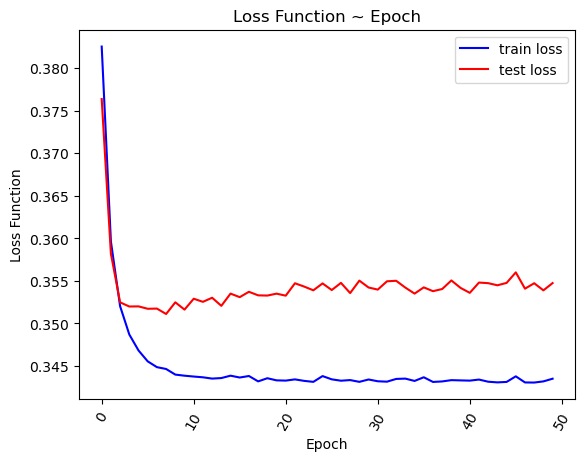

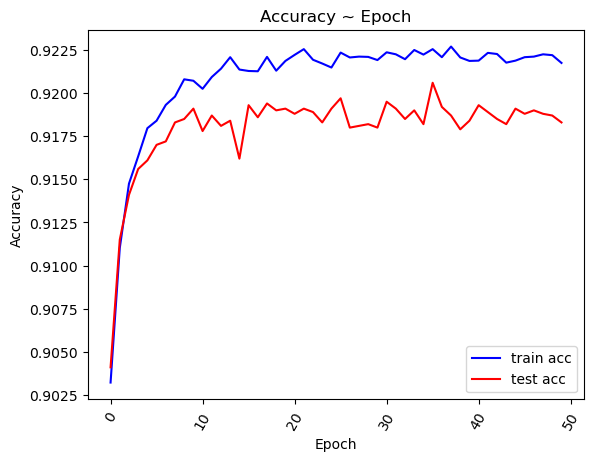

In [63]:
if __name__ == "__main__":

    cfg_idx = 'setting_6'
    
# configuration in setting 6:
#     {
#     "num_epoches" : 50,
#     "batch_size" : 600,
#     "learning_rate" : 0.1,
#     "learning_decay" : 0,
#     "decay_factor" : 0.75,
#     "momentum" : 0,
#     "lambda" : 0.01,
#     "mu" : 0.9
# }
    
    import logging
    logging.basicConfig(filename="./logs/{}.log".format(cfg_idx), filemode="w", format="%(message)s", level=logging.DEBUG)
    
    main(cfg_idx)

## 13. (To finish, 3 pts) Create a new configuration file for setting 7 (see below) and train your model

Epoch [1/50], Batch [100/100], Loss 0.3983
Epoch 1/50, Train Loss 0.5859, Train Acc 0.8959, Test Loss 0.5755, Test Acc 0.8975
Epoch [2/50], Batch [100/100], Loss 0.4247
Epoch 2/50, Train Loss 0.5844, Train Acc 0.8985, Test Loss 0.5756, Test Acc 0.9012
Epoch [3/50], Batch [100/100], Loss 0.4407
Epoch 3/50, Train Loss 0.5846, Train Acc 0.8994, Test Loss 0.5747, Test Acc 0.9011
Epoch [4/50], Batch [100/100], Loss 0.4100
Epoch 4/50, Train Loss 0.5848, Train Acc 0.8988, Test Loss 0.5760, Test Acc 0.9008
Epoch [5/50], Batch [100/100], Loss 0.3810
Epoch 5/50, Train Loss 0.5848, Train Acc 0.8985, Test Loss 0.5759, Test Acc 0.9004
Epoch [6/50], Batch [100/100], Loss 0.4184
Epoch 6/50, Train Loss 0.5843, Train Acc 0.8987, Test Loss 0.5750, Test Acc 0.9007
Epoch [7/50], Batch [100/100], Loss 0.3753
Epoch 7/50, Train Loss 0.5846, Train Acc 0.8990, Test Loss 0.5750, Test Acc 0.8994
Epoch [8/50], Batch [100/100], Loss 0.4022
Epoch 8/50, Train Loss 0.5852, Train Acc 0.8986, Test Loss 0.5744, Test Acc

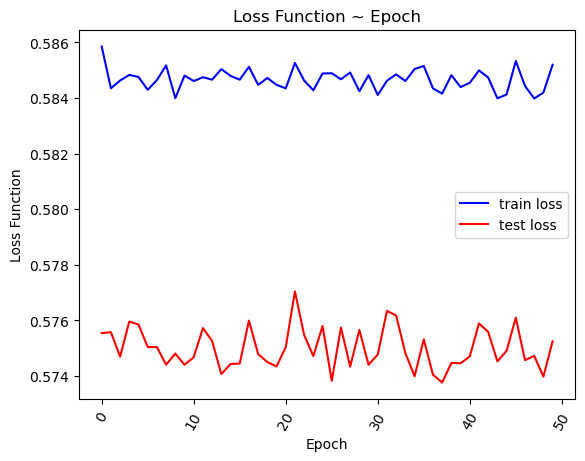

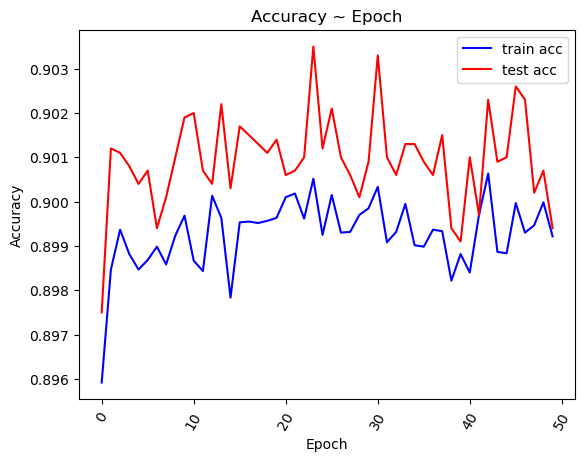

In [65]:
if __name__ == "__main__":

    cfg_idx = 'setting_7'
    
# configuration in setting 7:
#     {
#     "num_epoches" : 50,
#     "batch_size" : 600,
#     "learning_rate" : 0.1,
#     "learning_decay" : 0,
#     "decay_factor" : 0.75,
#     "momentum" : 0,
#     "lambda" : 0.1,
#     "mu" : 0.9
# }
    
    
    import logging
    logging.basicConfig(filename="./logs/{}.log".format(cfg_idx), filemode="w", format="%(message)s", level=logging.DEBUG)
    
    main(cfg_idx)

## 14. (To finish, 4 pts each question, 20 pts in total) Answer the following five questions

### Q1 (4 pts): What can we learn by comparing results of setting 1 and setting 2? Please analyse your observation/conclusion

**Answer**:In Setting 1, both the training accuracy and test accuracy are high, and there's a small gap between them,which indicates the model generalizes well. For setting 2, the test accuracy is much lower than the training accuracy,indicating the model is overfitting.




### Q2 (4 pts): What can we learn by comparing results of setting 2 and setting 3? Please analyse your observation/conclusion

**Answer**:Compared to Setting 2, Settings 3 converges quickly on the training loss and the test loss remains high. Also, the test accuracy is lower than the training accuracy.




### Q3 (4 pts): What can we learn by comparing results of setting 3 and setting 4? Please analyse your observation/conclusion

**Answer**:For setting 4, which uses a learning rate of 0.01,the training curve for both loss function and accuracy become smoother. And it reduces the gaps between the training and test loss as well as the training and test accuracy.



### Q4 (4 pts): What can we learn by comparing results of setting 2 and 5 (or 6)? Please analyse your observation/conclusion

**Answer**:Compared to Setting2, the test loss in setting 5 is slightly higher, but overall there is no significant different in the loss and accuracy curves between two settings. In contrast, setting 6 shows greater fluctuations in both the training and test lost and accuracy compared to Setting 2 and 5.



### Q5 (4 pts): What may happen to setting 7, compared to settings 2, 5 and 6?

**Answer**: Setting 7 may show greater fluctuations than settings 2 ,5 and 6,and its training and test curvelower accuracy and high loss because the  regularization is increrased.



In [2]:
# convert this file "HW1_to_Canvas.ipynb" to "HW1_to_Canvas.html"
!jupyter nbconvert --to html HW1_to_Canvas.ipynb 

[NbConvertApp] Converting notebook HW1_to_Canvas.ipynb to html
[NbConvertApp] Writing 656244 bytes to HW1_to_Canvas.html
